# Run hacked AlphaFold2 on the designed paired state Y's

### Imports

In [2]:
# %load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /home/broerman/crispy_shifty/projects/OPS/round_1/design
running on node: sofia


Note: We want to use perlmutter

### Fix the paths
Necessary because we are on perlmutter

In [3]:
sys.path.insert(0, "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam")
from crispy_shifty.utils.io import fix_path_prefixes

pairs = "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam/projects/OPS/round_1/design/09_mpnn_paired_states/mpnn_paired_states.pair"
new_pairs = fix_path_prefixes(
    find="/home/broerman/crispy_shifty",
    replace="/global/cfs/cdirs/m4129/projects/crispy_shifty_adam",
    file=pairs,
    overwrite=True,
)

/global/cfs/cdirs/m4129/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Run AF2 on the designed paired states Y's

In [8]:
# longest protein took 26 minutes to fold, so a 40 minute job limit should be more than enough

from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "10_fold_paired_states_Y"
design_list_file = "/global/cfs/cdirs/m4129/projects/crispy_shifty_adam/projects/OPS/round_1/design/09_mpnn_paired_states/mpnn_paired_states.pair"
output_path = os.path.join(f"/pscratch/sd/b/broerman/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
    ]
)
extra_kwargs = {"models": "1"}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.folding.fold_paired_state_Y",
    design_list_file=design_list_file,
    output_path=output_path,
    perlmutter_mode=True,
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
    time="40:00",
)

Run the following command with your desired environment active:
sbatch -a 1-2892 /pscratch/sd/b/broerman/10_fold_paired_states_Y/run.sh


Note: We rsync the perlmutter results, now back on the digs

### Collect scorefiles of the folded paired state Ys and concatenate

In [4]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "10_fold_paired_states_Y"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [5]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

simulation_name = "10_fold_paired_states_Y"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

100%|██████████| 82051/82051 [09:12<00:00, 148.63it/s]


### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
simulation_name = "10_fold_paired_states_Y"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

In [48]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
):
    display(scores_df)

,Y_mean_pae,Y_mean_pae_interaction,Y_mean_pae_interaction_AB,Y_mean_pae_interaction_BA,Y_mean_pae_intra_chain,Y_mean_pae_intra_chain_A,Y_mean_pae_intra_chain_B,Y_mean_plddt,Y_model,Y_pTMscore,Y_recycles,Y_rmsd_to_reference,Y_seed,Y_tol,Y_type,bb_clash,bb_clash_delta,bb_clash_delta_x,buns_parent,cms_AcB,cms_AnAc,cms_AnAcB,cms_AnB,designed_by,docked_helix,dslf_fa13,dssp,elapsed_time,exposed_hydrophobics_parent,fa_atr,fa_dun,fa_dun_dev,fa_dun_rot,fa_dun_semi,fa_elec,fa_intra_atr_xover4,fa_intra_elec,fa_intra_rep,fa_intra_rep_xover4,fa_intra_sol_xover4,fa_rep,fa_sol,fixed_resis,geometry_parent,hbond_bb_sc,hbond_lr_bb,hbond_sc,hbond_sr_bb,holes_all_parent,holes_core_parent,hxl_tors,interface,lk_ball,lk_ball_bridge,lk_ball_bridge_uncpl,lk_ball_iso,lk_ball_wtd,loop_dist,loop_sc,looped_length,mean_pae,mean_pae_interaction,mean_pae_interaction_AB,mean_pae_interaction_BA,mean_pae_intra_chain,mean_pae_intra_chain_A,mean_pae_intra_chain_B,mean_plddt,mismatch_probability_parent,model,mpnn_design_area,mpnn_msd_design_area,mpnn_msd_temperature,mpnn_temperature,new_loop_str,omega,pTMscore,p_aa_pp,packstat_parent,parent,parent_length,path_in,pdb,pivot_helix,pre_break_helix,pro_close,rama_prepro,recycles,ref,repeat_len,res_type_constraint,rmsd_to_reference,sap_parent,sc_AcB,sc_AnAc,sc_AnAcB,sc_AnB,sc_all_parent,score,score_per_res,score_per_res_parent,score_per_res_x,seed,shift,ss_sc,state,time,tol,topo,total_length,total_score,trim_n,trimmed_length,type,yhh_planarity
/pscratch/sd/b/broerman/10_fold_paired_states_Y/decoys/0049/10_fold_paired_states_Y_302e6e338e1e47df9f3c5becf79e6f2d.pdb.bz2,5.117170,5.112388,4.978621,5.246154,3.924380,5.112854,2.735907,90.270714,1,0.824694,3.0,1.501252,0,0.160987,monomer_ptm,293.942200,17.815065,1.932091,1.0,473.841583,374.080200,720.401489,268.211578,mpnn,4,0.0,LHHHHHHHHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHH...,8.053270,392.456696,-2944.086176,906.907806,62.567386,335.135848,528.583999,-893.143368,-161.599771,-104.851028,883.670342,144.691743,94.438314,4288.469759,1969.809432,"43,46,50,98,101,105,157,160,164,212,215,219",1.0,-11.898718,-13.150963,-41.325550,-392.298080,-0.615444,-1.891740,44.834165,normal,1489.463737,6.664236,49.743087,3492.803389,-49.446863,14.884428,0.664947,220.0,5.117170,5.112388,4.978621,5.246154,3.924380,5.112854,2.735907,90.270714,0.297028,1,interface,neighborhood,0.2,0.1,"107,108,109,110,111,112,113,114",107.022638,0.824694,-145.585113,0.526108,P09_2_strand,216,/home/broerman/crispy_shifty/projects/OPS/roun...,/home/broerman/crispy_shifty/projects/OPS/roun...,5,4,11.414017,-142.027280,3.0,16.07276,55,0.0,1.501252,37.347271,0.769668,0.805219,0.754817,0.754610,0.675830,-1406.362118,-2.881890,0.095576,0.168373,0,3,0.707168,P09_2_strand_p_5_s_3_d_4,2710.839946,0.160987,HHHHHHHH,251.0,638.890073,0,216,monomer_ptm,0.310191
/pscratch/sd/b/broerman/10_fold_paired_states_Y/decoys/0049/10_fold_paired_states_Y_e5f715567f6b4003bd65753d4fce2624.pdb.bz2,3.094182,3.685309,3.112042,4.258575,2.950210,2.815824,3.084595,96.274895,1,0.925628,3.0,0.922603,0,0.063612,monomer_ptm,75.072807,191.750107,56.481350,1.0,445.419403,338.546326,835.007385,427.214783,mpnn,5,0.0,LHHHHHHHHHHHHHHHHHHHHHHHHHHLLLHHHHHHHHHHHHHHHH...,9.009793,392.456696,-2985.557313,926.507905,67.592282,362.410831,502.859267,-940.479868,-161.131776,-105.991131,925.181086,144.273741,107.524540,3005.345123,1999.580284,"43,46,50,98,101,105,157,160,164,212,215,219",1.0,-9.710918,-15.372229,-27.279728,-410.793730,-0.615444,-1.891740,54.669289,upweight,1525.946884,6.335710,47.650276,3559.782547,-46.189368,16.473789,0.717896,220.0,3.094182,3.685309,3.112042,4.258575,2.950210,2.815824,3.084595,96.274895,0.297028,1,interface,full,0.2,0.1,"107,108,109,110,111,112,113,114",113.588667,0.925628,-135.185375,0.526108,P09_2_strand,216,/home/broerman/crispy_shifty/projects/OPS/roun...,/home/broerman/crispy_shifty/projects/OPS/roun...,4,4,10.545183,-181.606940,3.0,32.84907,55,0.0,0.922603,37.347271,0.736328,0.830872,0.753012,0.752916,0.675830,-1365.672350,-2.7

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [9]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"].sample(1000, random_state=0)
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

### Remove score terms we don't care about

In [10]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

2000
['Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_seed', 'Y_tol', 'Y_type', 'bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'fixed_resis', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_msd_design_area', 'mpnn_msd_temperature', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length'

In [11]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

to_plot = [
    "cms_AcB",
    "cms_AnAc",
    "cms_AnAcB",
    "cms_AnB",
    "designed_by",
    "interface",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_interaction_AB",
    "mean_pae_interaction_BA",
    "mean_pae_intra_chain",
    "mean_pae_intra_chain_A",
    "mean_pae_intra_chain_B",
    "mean_plddt",
    "mismatch_probability_parent",
    "pTMscore",
    "packstat_parent",
    "pdb",
    "recycles",
    "rmsd_to_reference",
    "sap_parent",
    "sc_AcB",
    "sc_AnAc",
    "sc_AnAcB",
    "sc_AnB",
    "sc_all_parent",
    "score_per_res",
    "score_per_res_parent",
    "ss_sc",
    "state",
    "topo",
]
print(to_plot)

['cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'interface', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'pTMscore', 'packstat_parent', 'pdb', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'score_per_res', 'score_per_res_parent', 'ss_sc', 'state', 'topo']


### Plot multistate design AF2 metrics

3it [00:00, 14.92it/s]


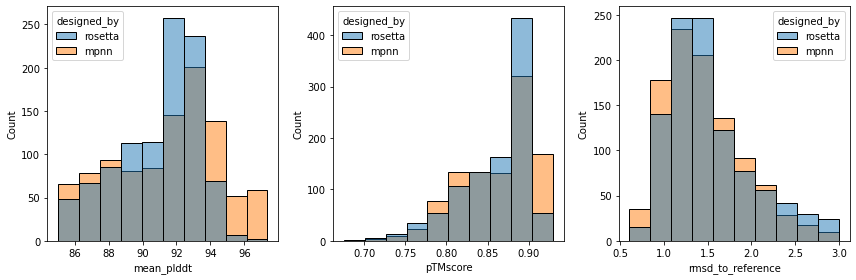

In [12]:
cols = [
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "af2_scores.png"))

<Figure size 864x864 with 0 Axes>

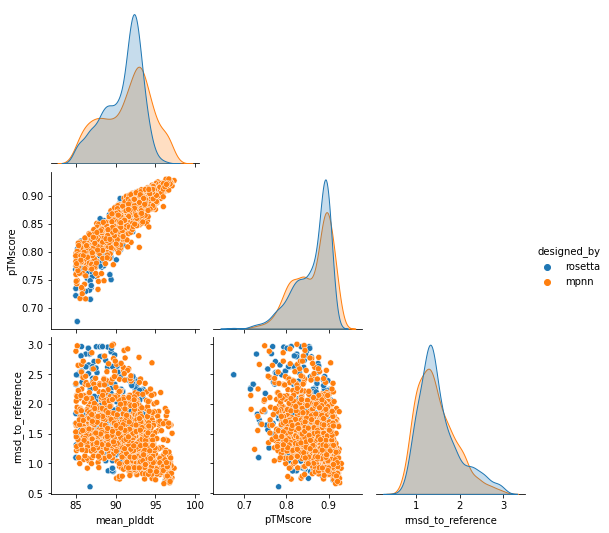

In [13]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "af2_scores_paired.png"))

3it [00:00, 16.55it/s]


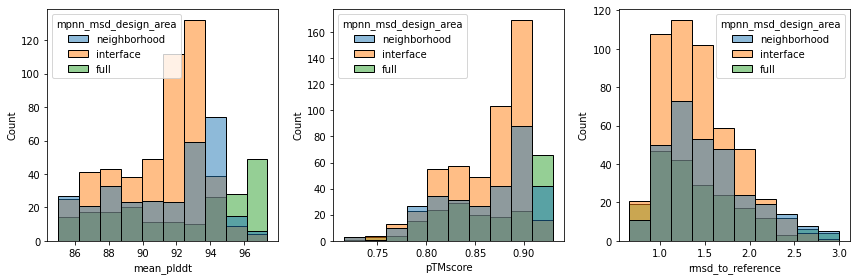

In [14]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "af2_scores_area.png"))

<Figure size 864x864 with 0 Axes>

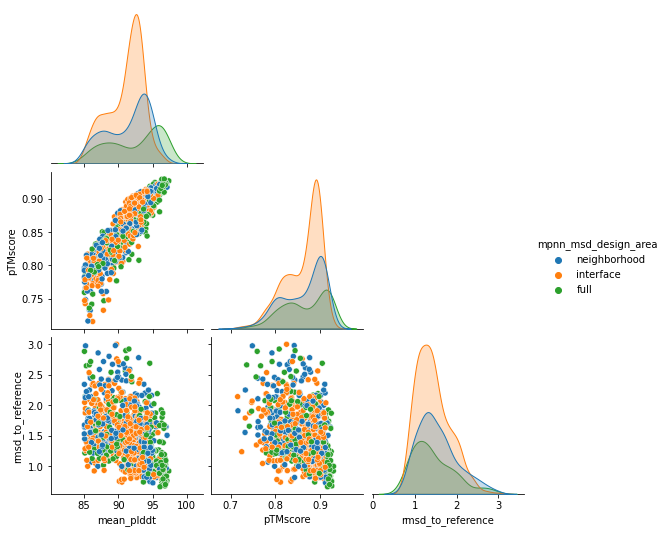

In [15]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "af2_scores_area_paired.png"))

### Plot interface metrics

6it [00:00, 17.69it/s]


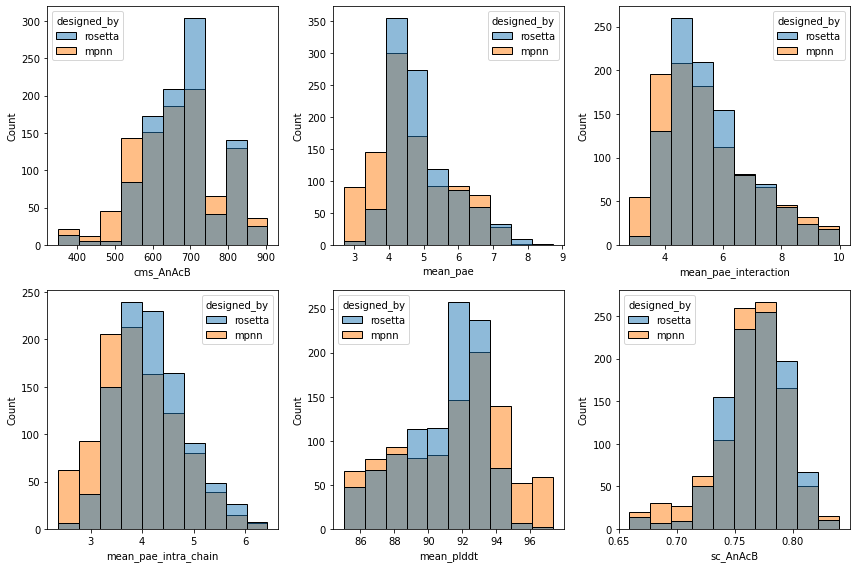

In [16]:
cols = [
    "cms_AnAcB",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
    "mean_plddt",
    "sc_AnAcB",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores.png"))

<Figure size 1728x1728 with 0 Axes>

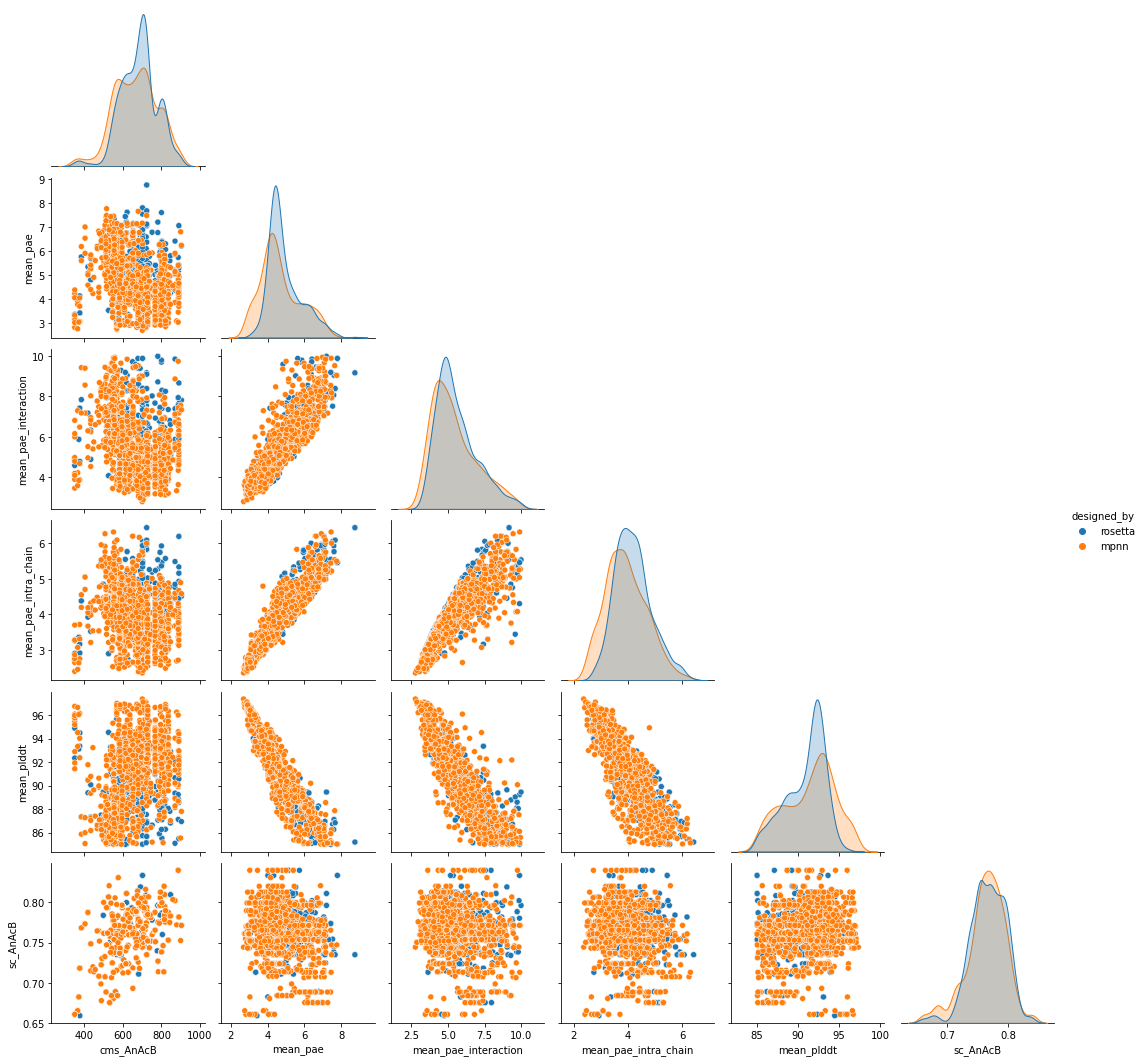

In [17]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "interface_scores_paired.png"))

### Plot effects of MPNN temperature and selector areas on interface metrics

6it [00:00, 16.66it/s]


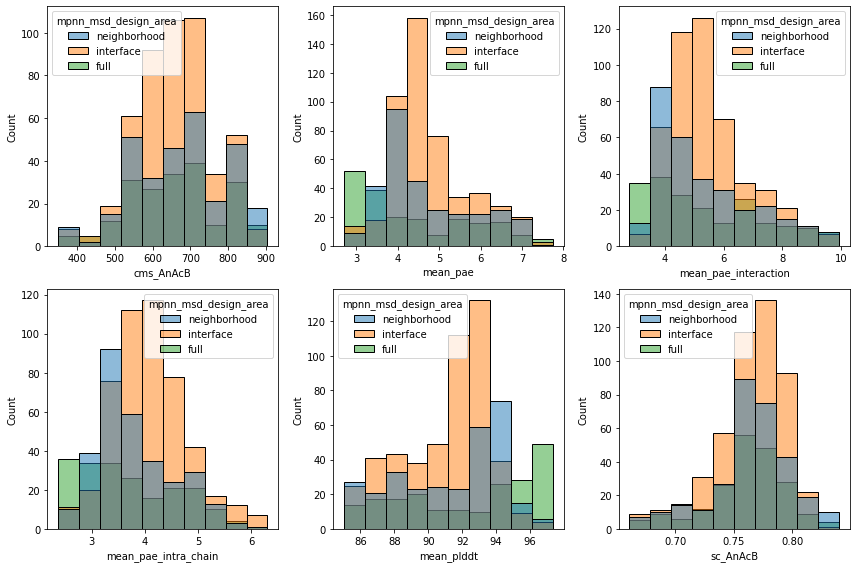

In [18]:
the_fig = histplot_df(
    df=mpnn,
    cols=cols,
    bins=10,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "interface_scores_area.png"))

<Figure size 1728x1728 with 0 Axes>

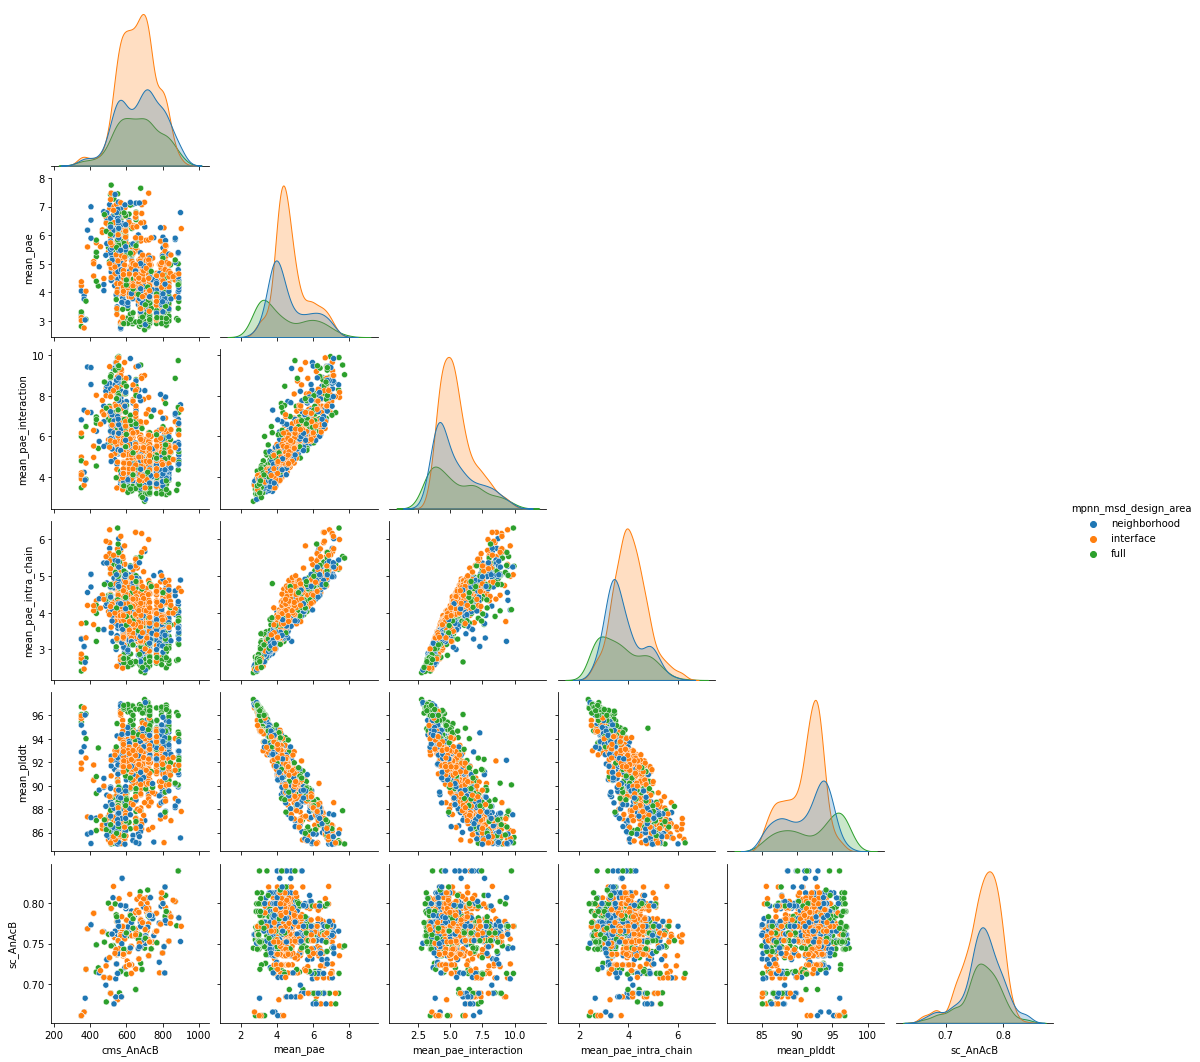

In [19]:
the_fig = pairplot_df(
    df=mpnn,
    cols=cols,
    hue="mpnn_msd_design_area",
)
plt.savefig(os.path.join(output_path, "interface_scores_area_paired.png"))

In [8]:
from IPython.display import display
with pd.option_context(
    'display.max_columns', None,
    'display.max_rows', None,
):
    display(scores_df.state.value_counts())

P09_2_strand_p_5_s_3_d_6        11642
P09_2_strand_p_4_s_4_d_5         9157
P09_2_strand_p_5_s_-4_d_6        7287
R6ST3_p_7_s_-4_d_8               6027
P09_2_strand_p_5_s_3_d_4         5930
P09_2_strand_p_4_s_-3_d_5        5091
P09_2_strand_p_4_s_4_d_3         3226
KW_b1_11_DY_p_5_s_3_d_6          3060
s8_LRT6_p_7_s_-4_d_8             2589
KWH1_chainA_01_p_4_s_4_d_3       2098
P09_2_strand_p_5_s_2_d_6         1999
sl_S2_08_p_7_s_-4_d_8            1990
R6_n6_p_7_s_-4_d_8               1550
R6_PO11_p_6_s_3_d_5              1373
R6PXX13_p_7_s_-4_d_8             1247
KW_b1_11_DY_p_5_s_7_d_4          1223
KW_b1_11_DY_p_4_s_-3_d_3         1210
P09_2_strand_p_4_s_-3_d_3         885
P09_2_strand_p_4_s_1_d_5          777
KW_b1_11_DY_p_5_s_-1_d_6          731
sl_S2_08_p_6_s_4_d_5              709
P09_2_strand_p_5_s_-5_d_6         688
KWH1_chainA_01_p_5_s_-4_d_6       683
P09_2_strand_p_5_s_-4_d_4         652
R6_PO11_p_6_s_6_d_5               617
KWH1_chainA_01_p_4_s_-3_d_3       614
R6ST3_p_6_s_

In [33]:
print(len(scores_df))
print(scores_df.state.nunique())
print(scores_df.parent.nunique())

82051
118
20


start here

### Filter the whole df

In [49]:
query = "rmsd_to_reference < 2"

filtered_df = scores_df.query(query)
print(len(filtered_df))
print(filtered_df.state.nunique())
print(filtered_df.parent.nunique())

72192
115
19


In [ ]:
all_states = set(filtered_df.state.values)
state_dfs = []
for state in all_states:
    state_df = filtered_df[filtered_df.state == state]
    state_df.sort_values(by="mean_plddt", inplace=True, ascending=False)
    state_df = state_df.head(min(len(state_df), 1000))
    state_dfs.append(state_df)
filtered_df = pd.concat(state_dfs)
filtered_df

In [51]:
print(len(filtered_df))
print(filtered_df.state.nunique())
print(filtered_df.parent.nunique())

28451
115
19


In [40]:
print(len([v for v in filtered_df.designed_by.values if v == "rosetta"]))

297


6it [00:00,  8.69it/s]


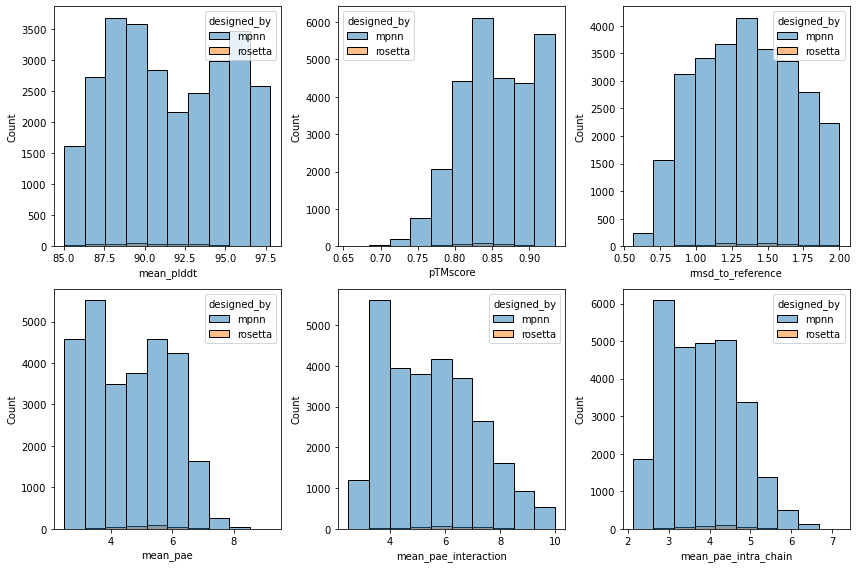

In [47]:
sys.path.insert(0, "/home/broerman/crispy_shifty")
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

cols = [
    "mean_plddt",
    "pTMscore",
    "rmsd_to_reference",
    "mean_pae",
    "mean_pae_interaction",
    "mean_pae_intra_chain",
]
the_fig = histplot_df(
    df=filtered_df,
    cols=cols,
    bins=10,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "filtered_af2_scores.png"))

### Sort the filtered df by length

In [52]:
filtered_df = filtered_df.sort_values("looped_length")

### Save a list of outputs
Sort by length

In [53]:
simulation_name = "10_fold_paired_states_Y"
output_path = os.path.join("/home/broerman/crispy_shifty/projects/OPS/round_1/design/", simulation_name)

with open(os.path.join(output_path, "folded_paired_states.list"), "w") as f:
    for path in tqdm(filtered_df.index):
        print(path, file=f)

100%|██████████| 28451/28451 [00:00<00:00, 604378.63it/s]


### Save a list of chunked outputs
50 per chunk

In [54]:
from more_itertools import ichunked

with open(os.path.join(output_path, "folded_paired_states.pair"), "w") as f:
    for paths in ichunked(tqdm(filtered_df.index), 50):
        line = "____".join(paths)
        print(line, file=f)

100%|██████████| 28451/28451 [00:00<00:00, 113256.71it/s]
